<a href="https://colab.research.google.com/github/Cdiezlop/ai4eng-udea-20252-cristian-diez/blob/main/02%20-%20preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocesamiento de datos - Entrega 2

Nombre: Cristian David Diez Lopez

Programa: Ingeniería de Sistemas  
Fecha: Noviembre 2025

# Preprocesado de Datos
Notebook correspondiente a la Entrega 2.
En este notebook se carga el archivo `train.csv` y se realiza el preprocesamiento de datos: imputación, codificación One-Hot y normalización.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')

In [2]:
# ===============================================================
# PASO 1: Configurar la API de Kaggle (Sube tu kaggle.json)
# ===============================================================
from google.colab import files
import os
import zipfile

# Pide subir el archivo
print("Por favor, sube tu archivo kaggle.json:")
uploaded = files.upload()

# Mueve el archivo al directorio de configuración de Kaggle
if 'kaggle.json' in uploaded:
    print("Moviendo kaggle.json...")
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle.json
else:
    print("¡Error! No se subió el archivo kaggle.json.")

# ===============================================================
# PASO 2: Descargar los datos de la competencia
# ===============================================================
print("\nDescargando datos de la competencia...")
# (Este es el comando que mencionaste)
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

# ===============================================================
# PASO 3: Descomprimir los datos
# ===============================================================
print("\nDescomprimiendo archivos...")
# Descomprime el archivo principal. El -o sobreescribe si ya existen.
!unzip -o udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip

print("\n¡Configuración lista! Los archivos CSV están en el directorio.")

Por favor, sube tu archivo kaggle.json:


Saving kaggle.json to kaggle.json
Moviendo kaggle.json...
chmod: cannot access '/root/.kaggle.json': No such file or directory

Descargando datos de la competencia...
  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.19GB/s]

Descomprimiendo archivos...
Archive:  udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               

¡Configuración lista! Los archivos CSV están en el directorio.






## Carga de datos

In [3]:
import pandas as pd

df = pd.read_csv("/content/train.csv", encoding='utf-8', nrows=20000)
print(f"Usando solo {df.shape[0]} filas para prueba de preprocesamiento.")



Usando solo 20000 filas para prueba de preprocesamiento.


## Limpieza básica

In [4]:


# 1. Elimina columnas duplicadas si existen
if 'F_TIENEINTERNET.1' in df.columns:
    df = df.drop(columns=['F_TIENEINTERNET.1'])
    print("Columna 'F_TIENEINTERNET.1' eliminada.")

# 2. Convierte tipo de dato a texto (si aplica)
if 'PERIODO_ACADEMICO' in df.columns:
    df['PERIODO_ACADEMICO'] = df['PERIODO_ACADEMICO'].astype(str)

# 3. Función para quitar tildes y pasar a mayúsculas
def quitar_tildes(texto):
    if isinstance(texto, str):
        texto = unicodedata.normalize('NFD', texto)
        texto = ''.join(c for c in texto if unicodedata.category(c) != 'Mn')
        return texto.upper()
    return texto

# Aplicar limpieza a todas las columnas de texto
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(quitar_tildes)

print("Limpieza básica completada.")

# Mostrar las columnas después de limpieza
df.info()


Columna 'F_TIENEINTERNET.1' eliminada.
Limpieza básica completada.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           20000 non-null  int64  
 1   PERIODO_ACADEMICO            20000 non-null  object 
 2   E_PRGM_ACADEMICO             20000 non-null  object 
 3   E_PRGM_DEPARTAMENTO          20000 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  19804 non-null  object 
 5   E_HORASSEMANATRABAJA         19105 non-null  object 
 6   F_ESTRATOVIVIENDA            19055 non-null  object 
 7   F_TIENEINTERNET              19234 non-null  object 
 8   F_EDUCACIONPADRE             19331 non-null  object 
 9   F_TIENELAVADORA              18860 non-null  object 
 10  F_TIENEAUTOMOVIL             18743 non-null  object 
 11  E_PRIVADO_LIBERTAD           20000 non-null  object 
 12  E_PAGOM

Porcentaje de valores nulos por columna:
Series([], dtype: float64)


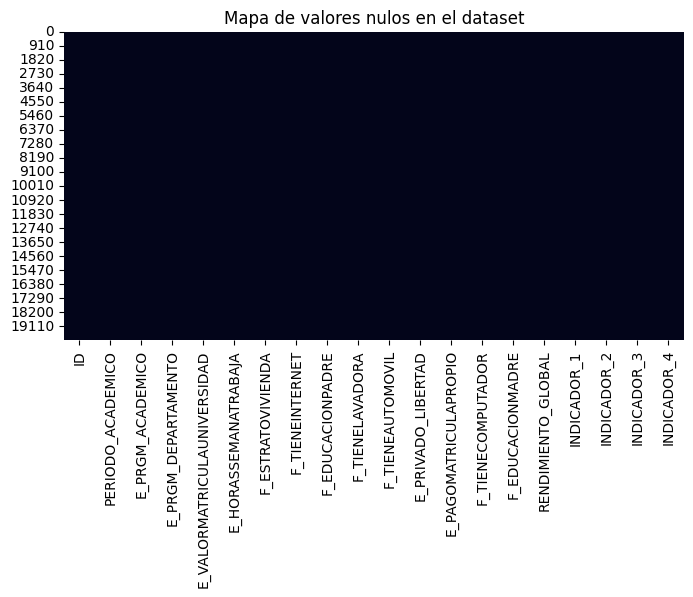

In [11]:
# Muestra el porcentaje de nulos por columna
missing = df.isnull().mean().sort_values(ascending=False)
print("Porcentaje de valores nulos por columna:")
print(missing[missing > 0].head(10))

# Visualización simple
plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Mapa de valores nulos en el dataset")
plt.show()


## Imputación de valores faltantes

In [6]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print(" Imputación de valores faltantes completada.")

# Verificar que ya no haya nulos
print("Nulos restantes:", df.isnull().sum().sum())


 Imputación de valores faltantes completada.
Nulos restantes: 0


In [7]:
cat_cols = ['PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO']



## Codificación One-Hot

In [8]:


encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_df = pd.DataFrame(encoder.fit_transform(df[cat_cols]))
encoded_df.columns = encoder.get_feature_names_out(cat_cols)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_encoded = pd.concat([df[num_cols].reset_index(drop=True),
                        encoded_df.reset_index(drop=True)], axis=1)

print(f"Dimensión después del One-Hot Encoding: {df_encoded.shape}")
df_encoded.head()



Dimensión después del One-Hot Encoding: (20000, 671)


,ID,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4,PERIODO_ACADEMICO_20183,PERIODO_ACADEMICO_20184,PERIODO_ACADEMICO_20194,PERIODO_ACADEMICO_20195,PERIODO_ACADEMICO_20196,...,E_PRGM_DEPARTAMENTO_META,E_PRGM_DEPARTAMENTO_NARINO,E_PRGM_DEPARTAMENTO_NORTE SANTANDER,E_PRGM_DEPARTAMENTO_PUTUMAYO,E_PRGM_DEPARTAMENTO_QUINDIO,E_PRGM_DEPARTAMENTO_RISARALDA,E_PRGM_DEPARTAMENTO_SANTANDER,E_PRGM_DEPARTAMENTO_SUCRE,E_PRGM_DEPARTAMENTO_TOLIMA,E_PRGM_DEPARTAMENTO_VALLE
0,904256.0,0.322,0.208,0.310,0.267,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,645256.0,0.311,0.215,0.292,0.264,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,308367.0,0.297,0.214,0.305,0.264,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,470353.0,0.485,0.172,0.252,0.190,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,989032.0,0.316,0.232,0.285,0.294,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalización de variables numéricas

In [9]:
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# resumen estadístico después de normalizar
df_encoded[num_cols].describe().T.head()


,count,mean,std,min,25%,50%,75%,max
ID,20000.0,-8.881784e-18,1.000025,-1.731162,-0.865841,0.001897,0.860869,1.734280
INDICADOR_1,20000.0,1.474376e-17,1.000025,-2.203750,-0.532806,-0.229743,0.368193,3.177672
INDICADOR_2,20000.0,-2.760459e-16,1.000025,-2.781799,-0.504776,-0.075149,0.526328,2.448909
INDICADOR_3,20000.0,-6.995293e-16,1.000025,-4.406608,-0.116534,0.236766,0.539594,0.977014
INDICADOR_4,20000.0,1.504574e-16,1.000025,-3.839686,-0.108953,0.315326,0.578672,1.017582


## Guardar dataset limpio y preprocesado

In [10]:
output_path = 'train_preprocesado.csv'
df_encoded.to_csv(output_path, index=False, encoding='utf-8')

print(f'Dataset preprocesado guardado en: {output_path}')
print(f'Dimensión final: {df_encoded.shape}')


Dataset preprocesado guardado en: train_preprocesado.csv
Dimensión final: (20000, 671)
